In [1]:
import importlib

import ase.io as aio
from ase.units import Bohr
import numpy as np
import glob

import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import bt_tools as bt
importlib.reload(bt)

import utils_qm as uqm

from matplotlib import pyplot as plt

def ref_scatter(ref):
    return(np.linspace(np.amin(ref), np.amax(ref), 3))


    
r2 = lambda y_r, y_f: ((y_f-y_r.mean())**2).sum()/((y_r-y_r.mean())**2).sum()

from sklearn.metrics import r2_score



In [2]:
def model_dbar(*args):
    globals()['model_dbar_lat'] = args[1:]
    var = args[0]
    alpha2, beta2, dbar2, alpha3, beta3, dbar3, alpha4, beta4, dbar4, b_prime = args[1:11]
    y_vec = []
    for x in var:
        Z1, Z2= x[0], x[1]
        
        if Z1 >= 6 and Z1 <= 9:
            y = -beta2**2*(Z1**(7/3)+Z2**(7/3))+alpha2-(b_prime**2+1/dbar2**2)*Z1*Z2
        elif Z1 >= 14 and Z1 <= 17:
            y = -beta3**2*(Z1**(7/3)+Z2**(7/3))+alpha3-(b_prime**2+1/dbar3**2)*Z1*Z2
        elif Z1 >= 32 and Z1 <= 35:
            y = -beta4**2*(Z1**(7/3)+Z2**(7/3))+alpha4-(b_prime**2+1/dbar4**2)*Z1*Z2
        y_vec.append(y)

    return(y_vec)

def model_dbar_gamma(*args):
    globals()['model_dbar_lat'] = args[1:]
    var = args[0]
    alpha2, beta2, dbar2, alpha3, beta3, dbar3, alpha4, beta4, dbar4, gamma, b_prime = args[1:12]
    y_vec = []
    for x in var:
        Z1, Z2= x[0], x[1]
        
        if Z1 >= 6 and Z1 <= 9:
            y = -beta2**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha2-(b_prime**2+1/dbar2**2)*Z1*Z2
        elif Z1 >= 14 and Z1 <= 17:
            y = -beta3**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha3-(b_prime**2+1/dbar3**2)*Z1*Z2
        elif Z1 >= 32 and Z1 <= 35:
            y = -beta4**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha4-(b_prime**2+1/dbar4**2)*Z1*Z2
        y_vec.append(y)

    return(y_vec)

In [5]:
e2 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/energies_single.txt')
e3 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_3/energies_single.txt')
e4 = np.loadtxt('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_4/energies_single.txt')

nuc_charges = [[6, 7, 8, 9], [14, 15, 16, 17], [32, 33, 34, 35]]

for e, z in zip([e2, e3, e4], nuc_charges):
    e_nuc = []
    for i in range(len(z)):
        for j in range(i, len(z)):
            e_nuc.append(z[i]*z[j])
#             e_nuc.append(0.0)
    e_nuc = np.array(e_nuc)
    e_el = (e[:,0] - e_nuc).copy()
    e[:,1] = e_el
    e[:,2] = e_nuc


energies = np.concatenate((e2, e3, e4), axis = 0)

In [6]:
# initial guess for parameters
b2 = bt.BDE_set(e2, [nuc_charges[0]])
b3 = bt.BDE_set(e3, [nuc_charges[1]])
b4 = bt.BDE_set(e4, [nuc_charges[2]])

for b in [b2, b3, b4]:
    b.fit(model_dbar, [1]*10)
    
b_prime_ini = (b2.params[0][-1]+b3.params[0][-1]+b4.params[0][-1])/3
alpha2, beta2, dbar2 = b2.params[0][0], b2.params[0][1], b2.params[0][2]
alpha3, beta3, dbar3 = b3.params[0][3], b3.params[0][4], b3.params[0][5]
alpha4, beta4, dbar4 = b4.params[0][6], b4.params[0][7], b4.params[0][8]

p0 = [alpha2, beta2, 1, alpha3, beta3, 1, alpha4, beta4, 1, b_prime_ini]

gamma_ini = np.sqrt(7/3)
p0_gamma = [alpha2, beta2, dbar2, alpha3, beta3, dbar3, alpha4, beta4, dbar4, gamma_ini, b_prime_ini]

p0_gamma2 = [alpha2, beta2, 1, alpha3, beta3, 1, alpha4, beta4, 1, 1, b_prime_ini]

In [7]:
b_global = bt.BDE_set(energies, nuc_charges)
b_global_gamma = bt.BDE_set(energies, nuc_charges)
b_global_gamma2 = bt.BDE_set(energies, nuc_charges)

b_global.fit(model_dbar, p0)
b_global_gamma.fit(model_dbar_gamma, p0_gamma)
b_global_gamma2.fit(model_dbar_gamma, p0_gamma2)

<ipython-input-2-958cb116e735>:28: RuntimeWarning: overflow encountered in double_scalars
  y = -beta2**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha2-(b_prime**2+1/dbar2**2)*Z1*Z2
<ipython-input-2-958cb116e735>:30: RuntimeWarning: overflow encountered in double_scalars
  y = -beta3**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha3-(b_prime**2+1/dbar3**2)*Z1*Z2
<ipython-input-2-958cb116e735>:32: RuntimeWarning: overflow encountered in double_scalars
  y = -beta4**2*(Z1**(gamma**2)+Z2**(gamma**2))+alpha4-(b_prime**2+1/dbar4**2)*Z1*Z2


In [8]:
print(b_global_gamma.params[0][-2]**2)
print(b_global_gamma2.params[0][-2]**2)

2.332474833936105
2.341348272420465


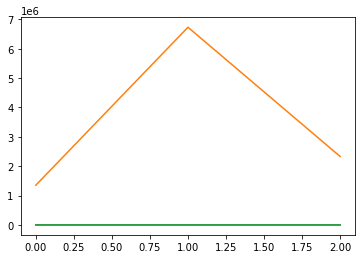

In [9]:
plt.plot(b_global.params[0][[2,5,8]]**2)
plt.plot(b_global_gamma.params[0][[2,5,8]]**2)
plt.plot(b_global_gamma2.params[0][[2,5,8]]**2)

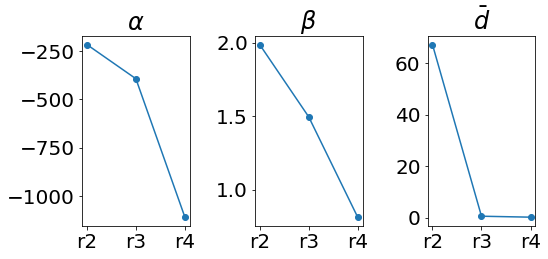

In [11]:
alpha_ind = np.array([0, 3, 6])
beta_ind = alpha_ind + 1
dbar_ind = alpha_ind + 2

xname = ['r2', 'r3', 'r4']

plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = [8,4]
fig, ax = plt.subplots(1,3)
for b in [b_global]:

    ax[0].plot(xname, b.params[0][alpha_ind], '-o')
    ax[1].plot(xname, b.params[0][beta_ind]**2, '-o')
    ax[2].plot(xname, b.params[0][dbar_ind]**2, '-o')

ylabels = [r'$\alpha$ (kcal/mol)', r'$\beta$', r'$\bar{d}$']
for i, t in enumerate([r'$\alpha$', r'$\beta$', r'$\bar{d}$']):
    ax[i].set_title(t)
#     ax[i].set_ylabel(ylabels[i])
fig.tight_layout()
# plt.savefig('/home/sahre/work/bonding_trends/figures/coeffs.png', bbox_inches = 'tight')

In [12]:
comp_names = []
for els in [['C', 'N', 'O', 'F'], ['Si', 'P', 'S', 'Cl'], ['Ge', 'As', 'Se', 'Br']]:
    for i in range(4):
        for j in range(i, 4):
            comp_names.append(f'{els[i]}{els[j]}')

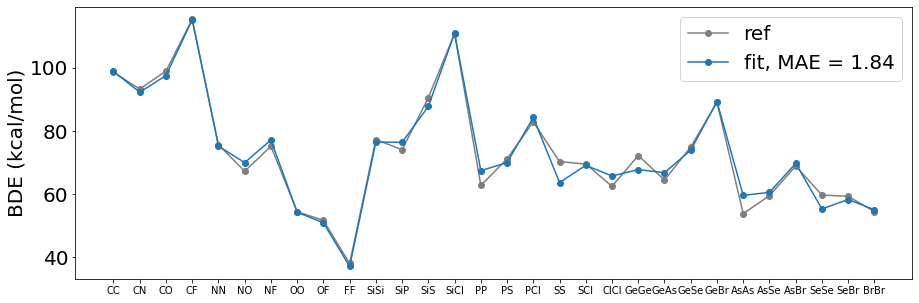

In [13]:
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = [15,5]

plt.plot(comp_names, b_global.bde, '-o',label = 'ref', color = 'tab:grey')
plt.plot(b_global.bde_fitted, '-o', label = f"fit, MAE = {np.round(b_global.mae, 2)}")

# plt.plot(b_global.bde_fitted, label = r"$\gamma = 7/3$, $\bar{d}_{\rm{ini}} = 1$")
# plt.plot(b_global_gamma.bde_fitted, '--', label = r"$\gamma = \gamma_{\rm{opt}}$")
# plt.plot(b_global_gamma2.bde_fitted, '--', label = r"$\gamma = \gamma_{\rm{opt}}$, $\bar{d}_{\rm{ini}} = 1$")

# plt.legend(bbox_to_anchor=(1.05, 1))

plt.xticks(fontsize=10)
plt.ylabel('BDE (kcal/mol)')

plt.legend()

# plt.savefig('/home/sahre/work/bonding_trends/figures/BDE_dbar.png', bbox_inches = 'tight')

In [14]:
print(b_global.mae)
print(b_global_gamma.mae)
print(b_global_gamma2.mae)

1.8388016282711732
2.732365390856261
1.840364696699056


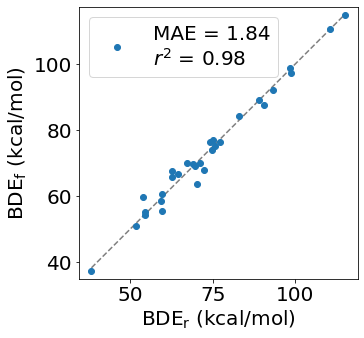

In [15]:
global_r2 = np.round(r2_score(b_global.bde, b_global.bde_fitted),2)

plt.rcParams['figure.figsize'] = [5,5]
plt.plot(ref_scatter(b_global.bde), ref_scatter(b_global.bde), '--', color = 'tab:grey')
plt.plot(b_global.bde, b_global.bde_fitted, 'o', color = 'tab:blue', label = f'MAE = {np.round(b_global.mae, 2)}\n$r^2$ = {global_r2}')
plt.axis('equal')
plt.xlabel(r'$\mathregular{BDE_r}$ (kcal/mol)')
plt.ylabel('$\mathregular{BDE_f}$ (kcal/mol)')
plt.legend()
# plt.savefig('/home/sahre/work/bonding_trends/figures/BDE_dbar_scatter.png', bbox_inches = 'tight')